# Matching

ECON526

Paul Schrimpf (University of British Columbia)

# Introduction

## Setting

-   Potential outcomes $(Y(0), Y(1))$
-   Treatment $T \in \{0,1\}$
-   Observe $Y = Y(T)$
-   Covariates $X$
-   Assume conditional independence $(Y(0),Y(1)) \perp T | X$

$$
\def\Er{{\mathrm{E}}}
\def\En{{\mathbb{En}}}
\def\cov{{\mathrm{Cov}}}
\def\var{{\mathrm{Var}}}
\def\R{{\mathbb{R}}}
\newcommand\norm[1]{\left\lVert#1\right\rVert}
\def\rank{{\mathrm{rank}}}
\newcommand{\inpr}{ \overset{p^*_{\scriptscriptstyle n}}{\longrightarrow}}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
\DeclareMathOperator*{\argmin}{argmin}
$$

## Why not regression?

-   Average treatment effect $$
    ATE = \int \Er[Y|T=1,X=x] - \Er[Y|T=0,X=x] dP(x)
    $$
-   Regression gives the best linear approximation to $\Er[Y|T,X]$, so
    why not just estimate linear regression $$
    Y_i = \hat{\alpha} T_i + X_i'\hat{\beta} + \hat{\epsilon}_i
    $$ and, and then use $\hat{\alpha}$ as an estimate of the ATE?

## Why not regression?

-   Partial out (Frish-Waugh-Lovell theorem) $$
    \begin{align*}
    \hat{\alpha} = & \frac{\frac{1}{n} \sum_{i=1}^n Y_i (T_i - X_i'(X'X)^{-1}X'T)}
      {\frac{1}{n} \sum_{i=1}^n (T_i - X_i'(X'X)^{-1}X'T)^2} \\
      \inprob & \Er\left[Y_i \underbrace{\frac{T_i - X_i'\pi}{\Er[(T_i - X_i'\pi)^2]}}_{\equiv \omega(T_i,X_i)}\right] \\
      = & \Er\left[Y_{0,i} \omega(T_i,X_i)\right] + \Er\left[(Y_{1,i}-Y_{0,i}) \omega(T_i,X_i)T_i\right]
    \end{align*}
    $$ where
    $\pi = \argmin_{\tilde{\pi}} \Er[(T_i - X_i'\tilde{\pi})^2]$

-   Note: $\Er[\omega(T,X)] = 0$, $\Er[T\omega(T,X)] = 1$

## Why not regression?

-   $\plim \hat{\alpha} = \Er\left[Y_{0,i} \omega(T_i,X_i)\right] + \Er\left[(Y_{1,i}-Y_{0,i}) \omega(T_i,X_i)T_i\right]$

-   What can be in the range of
    $\omega(T,X) = \frac{T - X'\pi}{\Er[(T_i - X_i'\pi)^2]}$?

## Why not regression?

In [1]:
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import scipy
style.use("fivethirtyeight")

In [2]:
np.random.seed(1234)

def simulate(n, pi=np.array([0,1])):
    X = np.random.randn(n, len(pi))
    X[:,0] = 1
    P = np.clip(scipy.stats.norm.cdf(X @ pi), 0.05, 0.95)
    T = 1*(np.random.rand(n) < P)
    Ey0x = np.zeros(n)
    Ey1x = np.exp(3*(X[:,1]-2))
    y0 = Ey0x + np.random.randn(n)
    y1 = Ey1x + np.random.randn(n)
    y = T*y1 + (1-T)*y0
    return(X,T,y,y0,y1, Ey0x, Ey1x, P)

X,T,y,y0,y1,Ey0x,Ey1x,P = simulate(4000)

pihat = np.linalg.solve(X.T @ X, X.T @ T)
w = T - X @ pihat
w = w/np.mean(w**2);

## Why not regression?

In [3]:
TX = np.hstack((T.reshape(len(T),1),X))
abhat = np.linalg.solve(TX.T @ TX, TX.T @ y)
ahat = abhat[0]
print(ahat)

-0.11952795827329041

In [4]:
np.mean(y1-y0)

np.float64(0.1172689998868494)

-   Weights, $\omega(T,X)$, are not all positive, so the regression
    estimate can be negative even if $\Er[Y(1) | X] - \Er[Y(0)|X]$ is
    positive everywhere

## Why not regression?

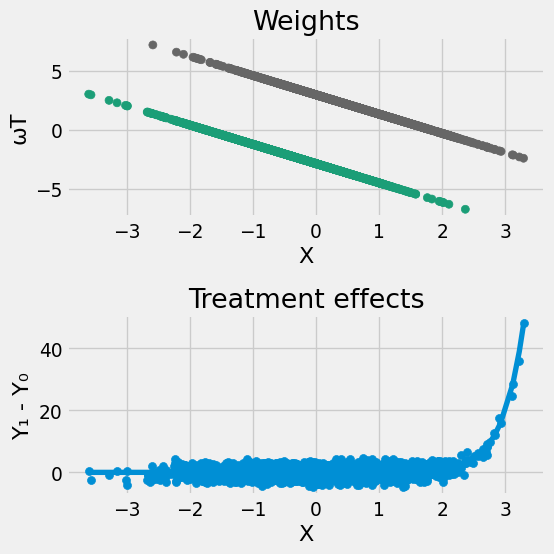

In [5]:
import matplotlib.cm as cm
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# Create a scatter plot for the first panel (left)
axes[0].scatter(X[:,1], w, c=T, cmap=cm.Dark2)
axes[0].set_xlabel("X")
axes[0].set_ylabel("ωT")
axes[0].set_title("Weights")

axes[1].scatter(X[:,1], y1-y0, label="TE")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y₁ - Y₀")
axes[1].set_title("Treatment effects")
sort_idx = np.argsort(X[:,1])
axes[1].plot(X[sort_idx,1], Ey1x[sort_idx]-Ey0x[sort_idx], label="E[y1-y0|x]")

# Display the plot
plt.tight_layout()  # Ensure proper layout spacing
plt.show()

# Matching

## Matching

-   If not regression, then what? $$
    ATE = \int \Er[Y|T=1,X=x] - \Er[Y|T=0,X=x] dP(x)
    $$

## Plug-in estimator

-   Plug in estimator: $$
    \widehat{ATE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{E}[Y|T=1,X=X_i] - \hat{E}[Y|T=0,X=X_i] \right)
    $$ where $\hat{E}[Y|T,X]$ is some flexible estimator for
    $\Er[Y|T,X]$
    -   if $X$ is discrete, $\hat{E}$ can be conditional averages or
        equivalently, “saturated” regression
    -   if $X$ continuous, $\hat{E}$ can be some nonparametric
        regression estimator
    -   Original approaches to this problem used nearest neighbor
        matching to estimate $\hat{E}[Y|T,X]$
-   Downside:
    -   Difficult statistical properties — choice of tuning parameters,
        strong assumptions needed, failure of bootstrap for nearest
        neighbors Abadie and Imbens (2008)

## Propensity Score

-   Let $p(X) = P(T=1|X=X)$
-   Note: $$
    \begin{align*}
    \Er[Y|X,T=1] - \Er[Y|X,T=0] = & E\left[\frac{Y T}{p(X)}|X \right] - E\left[\frac{Y(1-T)}{1-p(X)}|X \right] \\
    = & E\left[ Y \frac{T - p(X)}{p(X)(1-p(X))} | X \right]
    \end{align*}
    $$

## Propensity Score

-   so $$
    ATE = \Er\left[ \frac{Y T}{p(X)} -  \frac{Y(1-T)}{1-p(X)}\right] = \Er\left[ Y \frac{T - p(X)}{p(X)(1-p(X))} \right]
    $$

## Inverse propensity weighting

-   Estimator $$
    \widehat{ATE}^{IPW} = \frac{1}{n} \sum_{i=1}^n \frac{Y_iT_i}{\hat{p}(X_i)} - \frac{Y_i(1-T_i)}{1-\hat{p}(X_i)}
    $$ where $\hat{p}(X)$ is some flexible estimator for $P(T=1|X)$

-   Downside:

    -   Difficult statistical properties — choice of tuning parameters,
        strong assumptions needed

## Doubly Robust Estimator

-   Combines plug-in and IPW estimators
-   Estimator $$
    \begin{align*}
    \widehat{ATE}^{DR} = & \frac{1}{n} \sum_{i=1}^n \hat{E}[Y|T=1,X=X_i] - \hat{E}[Y|T=0,X=X_i] + \\
    & + \frac{1}{n} \sum_{i=1}^n  \frac{T_i(Y_i - \hat{E}[Y|T=1,X=X_i])}{\hat{p}(X_i)} - \\
    & - \frac{(1-T_i)(Y_i - \hat{E}[Y|T=0,X=X_i])} {1-\hat{p}(X_i)}
    \end{align*}
    $$

## Doubly Robust Estimator

-   Doubly robust in that:
    -   Consistent as long as either $\hat{p}(X) \inprob p(X)$ or
        $\hat{E}[Y|T,X] \inprob \Er[Y|T,X]$
    -   Insensitive to small changes in $\hat{p}(X)$ or $\hat{E}[Y|T,X]$
-   Allows nicer statistical properties
    -   Weaker assumptions needed
    -   Asymptotic distribution is the same as if $p(X)$ and
        $\Er[Y|T,X]$ were known

## Software

-   Advice: use the doubly robust estimator with nonparametric estimates
    for $\hat{E}[Y|T,X]$ and $\hat{p}(X)$
-   Recommended package:
    -   [doubleml](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-models-irm)

## Example: simulation

-   Infeasible estimator: average of $Y(1) - Y(0)$

In [6]:
se = np.sqrt(np.var(y1-y0)/len(y1))
ate = np.mean(y1-y0)
print(f"Infeasible estimator with potential outcomes observed = {ate:.2} with 95% CI = [{ate-1.96*se:.2},{ate+1.96*se:.2}]\n")

Infeasible estimator with potential outcomes observed = 0.12 with 95% CI = [0.058,0.18]


-   Infeasible estimator: doubly robust with true $\Er[Y(T)|X]$ and
    $p(X)$

In [7]:
aipw = Ey1x - Ey0x + T*(y - Ey1x)/P - (1-T)*(y - Ey0x)/(1-P)
se = np.sqrt(np.var(aipw)/len(aipw))
print(f"Infeasible estimator with true E[y1-y0|x] = and p(x) {np.mean(aipw):.2} with 95% CI = [{np.mean(aipw)-1.96*se:.2},{np.mean(aipw)+1.96*se:.2}]\n")

Infeasible estimator with true E[y1-y0|x] = and p(x) 0.15 with 95% CI = [0.057,0.24]


## Example: choosing flexible estimators

In [8]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegressionCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

gamma = 0.5
nc = 100
models = [
    Pipeline([('rbf',RBFSampler(gamma=gamma, random_state=1, n_components=nc)),
              ('lasso',LassoCV(max_iter=10_000, tol=1e-2, n_jobs=-1, selection='random',
                               alphas=10**np.linspace(-3,3,20)))]),
    Pipeline([('poly',PolynomialFeatures(degree=10)),
              ('scale', StandardScaler()),
              ('lasso',LassoCV(max_iter=10_000, n_jobs=-1, selection='random', tol=1e-2,
                               alphas=10**np.linspace(-3,3,20)))]),
    GradientBoostingRegressor(learning_rate=0.1, criterion="squared_error")]

for m in models :
    print(m)
    print(f"cross val R-squared {cross_val_score(m, X, y, cv=5).mean():.4} \n\n")

Pipeline(steps=[('rbf', RBFSampler(gamma=0.5, random_state=1)),
                ('lasso',
                 LassoCV(alphas=array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                         max_iter=10000, n_jobs=-1, selection='random',
                         tol=0.01))])
cross val R-squared 0.4365 


Pipeline(steps=[('poly', PolynomialFeatures(degree=10)),
                ('scale', StandardScaler()),
                ('lasso',
                 LassoCV(alphas=array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6

## Visualizing Fit

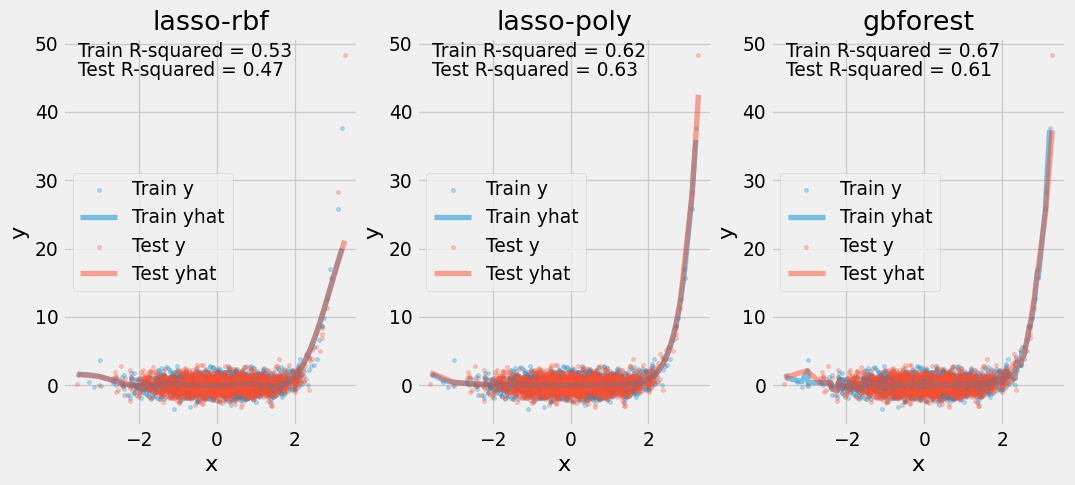

In [9]:
from sklearn.model_selection import train_test_split
names = ["lasso-rbf", "lasso-poly", "gbforest"]
X_train,  X_test,y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5498)
fig, ax = plt.subplots(1,3, figsize=(12,5))
ax = ax.flatten()
def r2(y,yhat) :
    return(1 - np.mean((y-yhat)**2)/np.var(y))
otr = np.argsort(X_train[:,1])
ote = np.argsort(X_test[:,1])

for i, m in enumerate(models):
    m.fit(X_train,y=y_train)
    yhat = m.predict(X_train)
    yhat_test = m.predict(X_test)
    ax[i].scatter(X_train[:,1], y_train, alpha=0.3, label="Train y", color="C0", marker=".")
    ax[i].plot(X_train[otr,1], yhat[otr], alpha=0.5, label="Train yhat", color="C0")
    ax[i].scatter(X_test[:,1], y_test, alpha=0.3, label="Test y", color="C1", marker=".")
    ax[i].plot(X_test[ote,1], yhat_test[ote], alpha=0.5, label="Test yhat", color="C1")
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    ax[i].set_title(names[i])
    ax[i].annotate(f"Train R-squared = {r2(y_train, yhat):.2}", (0.05, 0.95), xycoords='axes fraction')
    ax[i].annotate(f"Test R-squared = {r2(y_test, yhat_test):.2}", (0.05, 0.90), xycoords='axes fraction')
    ax[i].legend()

plt.show()

## Example: choosing flexible estimators

In [10]:
gamma = 0.5
nc = 100
models = [
    Pipeline([('rbf',RBFSampler(gamma=gamma, random_state=1, n_components=nc)),
              ('logistic',LogisticRegressionCV(n_jobs=-1, scoring='neg_log_loss'))]),
    Pipeline([('poly',PolynomialFeatures(degree=10)),
              ('scale', StandardScaler()),
              ('logistic',LogisticRegressionCV(n_jobs=-1, scoring='neg_log_loss'))]),
    GradientBoostingClassifier(learning_rate=0.1)]
for m in models :
    print(m)
    print(f"cross val log likelihood {cross_val_score(m, X, T, scoring='neg_log_loss', cv=5).mean():.4} \n\n")

Pipeline(steps=[('rbf', RBFSampler(gamma=0.5, random_state=1)),
                ('logistic',
                 LogisticRegressionCV(n_jobs=-1, scoring='neg_log_loss'))])
cross val log likelihood -0.5077 


Pipeline(steps=[('poly', PolynomialFeatures(degree=10)),
                ('scale', StandardScaler()),
                ('logistic',
                 LogisticRegressionCV(n_jobs=-1, scoring='neg_log_loss'))])
cross val log likelihood -0.5098 


GradientBoostingClassifier()
cross val log likelihood -0.5184 



## Example: Checking Overlap

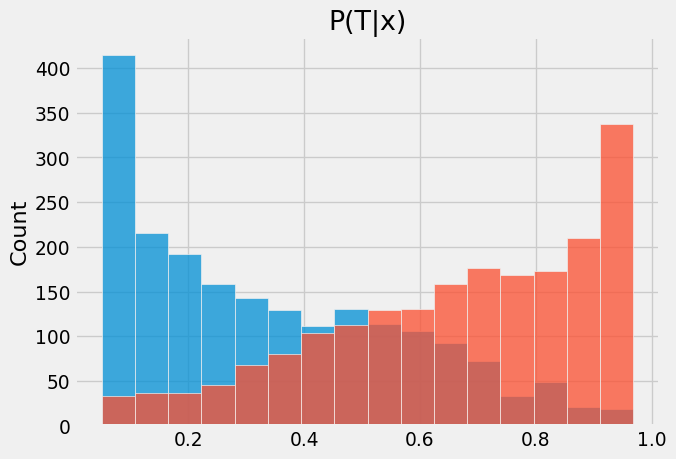

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import doubleml as dml
g = Pipeline([('poly',PolynomialFeatures(degree=10)),
              ('scale', StandardScaler()),
              ('lasso',LassoCV(max_iter=10_000, n_jobs=-1, selection='random', tol=1e-2,
                               alphas=10**np.linspace(-3,3,20)))])
m = Pipeline([('rbf',RBFSampler(gamma=gamma, random_state=1, n_components=nc)),
              ('logistic',LogisticRegressionCV(n_jobs=-1, scoring='neg_log_loss'))])

m.fit(X,T)

def plotp(model,X,d):
    fig,ax=plt.subplots()
    p = model.predict_proba(X)
    sns.histplot(p[d==0,1], kde = False,
                 label = "Untreated", ax=ax)
    sns.histplot(p[d==1,1], kde = False,
                 label = "Treated", ax=ax)
    ax.set_title('P(T|x)')
    return(fig)

fig=plotp(m, X, T)

## Example: Results

In [12]:
dmldata = dml.DoubleMLData.from_arrays(X, y, T)
dmlATE = dml.DoubleMLAPOS(dmldata, g, m, treatment_levels=[0, 1])
dmlATE.fit()
dmlATE.summary

In [13]:
dmlATE.causal_contrast(0).summary

In [14]:
aipw = Ey1x - Ey0x + T*(y - Ey1x)/P - (1-T)*(y - Ey0x)/(1-P)
se = np.sqrt(np.var(aipw)/len(aipw))
print(f"Infeasible estimator with true E[y1-y0|x] = and p(x) {np.mean(aipw):.2} with 95% CI = [{np.mean(aipw)-1.96*se:.2},{np.mean(aipw)+1.96*se:.2}]\n")

Infeasible estimator with true E[y1-y0|x] = and p(x) 0.15 with 95% CI = [0.057,0.24]


# Growth Mindset

## National Study of Learning Mindsets

-   Original study by Yeager et al. (2019)
-   Synthetic data created by Athey and Wager (2019), downloaded from
    Facure (2022)

## Data

In [15]:
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
style.use("fivethirtyeight")
pd.set_option("display.max_columns", 20)
datadir="./data"

In [16]:
data = pd.read_csv(datadir+"/learning_mindset.csv")
data.sample(5, random_state=431)

## Evidence of Confounding

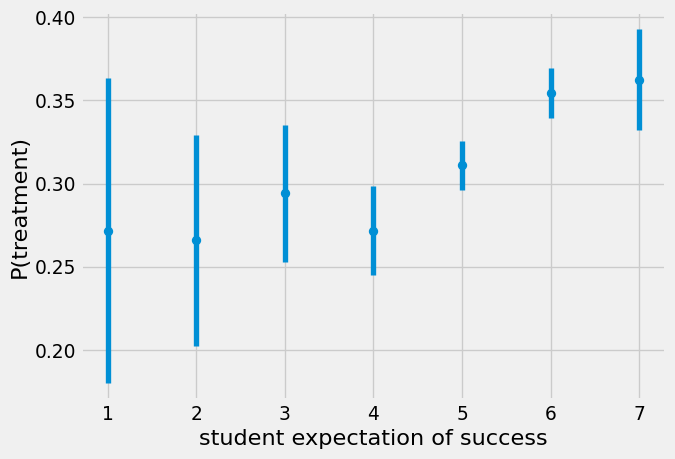

In [17]:
def std_error(x):
    return np.std(x, ddof=1) / np.sqrt(len(x))

grouped = data.groupby('success_expect')['intervention'].agg(['mean', std_error])
grouped = grouped.reset_index()

fig, ax = plt.subplots()
plt.errorbar(grouped['success_expect'],grouped['mean'],yerr=1.96*grouped['std_error'],fmt="o")
ax.set_xlabel('student expectation of success')
ax.set_ylabel('P(treatment)')
plt.show()

## Unadjusted estimate of ATE

In [18]:
print(smf.ols("achievement_score ~ intervention", data=data).fit(cov_type="HC3").summary().tables[1])

                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1538      0.012    -13.289      0.000      -0.176      -0.131
intervention     0.4723      0.021     22.968      0.000       0.432       0.513

In [19]:
print(smf.ols("achievement_score ~ intervention", data=data).fit(
    cov_type="cluster", cov_kwds={'groups': data['schoolid']}).summary().tables[1])

                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1538      0.036     -4.275      0.000      -0.224      -0.083
intervention     0.4723      0.025     19.184      0.000       0.424       0.521

## Unadjusted estimate of ATE

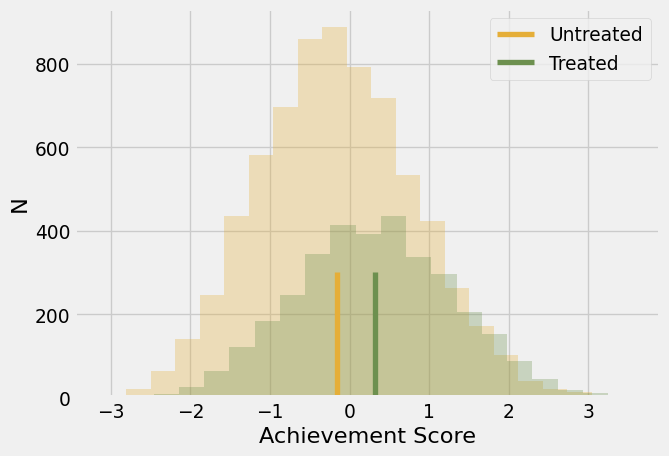

In [20]:
fig,ax=plt.subplots()
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
ax.set_xlabel("Achievement Score")
ax.set_ylabel("N")
plt.legend()
plt.show();

## Regression estimate of ATE

In [21]:
ols = smf.ols("achievement_score ~ intervention + success_expect + ethnicity + gender + frst_in_family + school_urbanicity + school_mindset + school_achievement + school_ethnic_minority + school_poverty + school_size",data=data).fit(cov_type="cluster", cov_kwds={'groups': data['schoolid']})
print(ols.summary().tables[1])

                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.7786      0.110    -16.214      0.000      -1.994      -1.564
intervention               0.3964      0.025     15.558      0.000       0.346       0.446
success_expect             0.3746      0.009     41.120      0.000       0.357       0.392
ethnicity                  0.0043      0.003      1.639      0.101      -0.001       0.009
gender                    -0.2684      0.016    -16.299      0.000      -0.301      -0.236
frst_in_family            -0.1310      0.019     -6.770      0.000      -0.169      -0.093
school_urbanicity          0.0573      0.036      1.613      0.107      -0.012       0.127
school_mindset            -0.1484      0.044     -3.341      0.001      -0.235      -0.061
school_achievement        -0.0253      0.055     -0.457      0.647      -0.134       0.083

## Regression estimate of ATE: weights

In [22]:
lpm = smf.ols("intervention ~ success_expect + ethnicity + gender + frst_in_family + school_urbanicity + school_mindset + school_achievement + school_ethnic_minority + school_poverty + school_size",data=data).fit(cov_type="cluster", cov_kwds={'groups': data['schoolid']})
w = lpm.resid / np.var(lpm.resid)
print(np.mean(data.achievement_score*w))

0.39640236033389553

## Regression estimate of ATE: weights

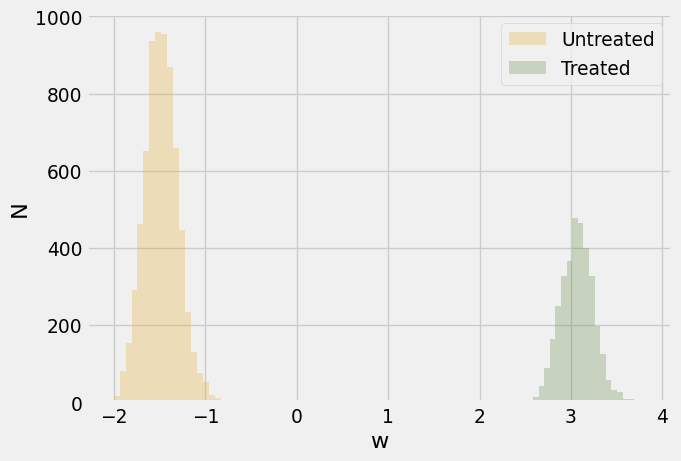

In [23]:
fig,ax=plt.subplots()
plt.hist(w[data.intervention==0], bins=20, alpha=0.3, color="C2", label="Untreated")
plt.hist(w[data.intervention==1], bins=20, alpha=0.3, color="C3", label="Treated")
ax.set_xlabel("w")
ax.set_ylabel("N")
plt.legend()
plt.show();

## Propensity Score Matching

In [24]:
categ = ["ethnicity", "gender", "school_urbanicity","success_expect"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

(10391, 38)

## Propensity Score Matching

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
import sklearn

def propensitymatching(T,Y,X,psmodel=LogisticRegressionCV(scoring='neg_log_loss'),neighbormodel=KNeighborsRegressor(n_neighbors=1,algorithm='auto',weights='uniform')):
    pfit = psmodel.fit(X,T)
    ps = pfit.predict_proba(X)[:,1]
    ey1 = neighbormodel.fit(ps[T==1].reshape(-1,1),Y[T==1])
    ey0 = sklearn.base.clone(neighbormodel).fit(ps[T==0].reshape(-1,1),Y[T==0])
    tex = ey1.predict(ps.reshape(-1,1)) - ey0.predict(ps.reshape(-1,1))
    ate = np.mean(tex)
    return(ate, tex,ps)

ate,tex,ps=propensitymatching(data_with_categ[T],data_with_categ[Y],data_with_categ[X])
print(ate)

0.4163456073819457

## Propensity Score Matching

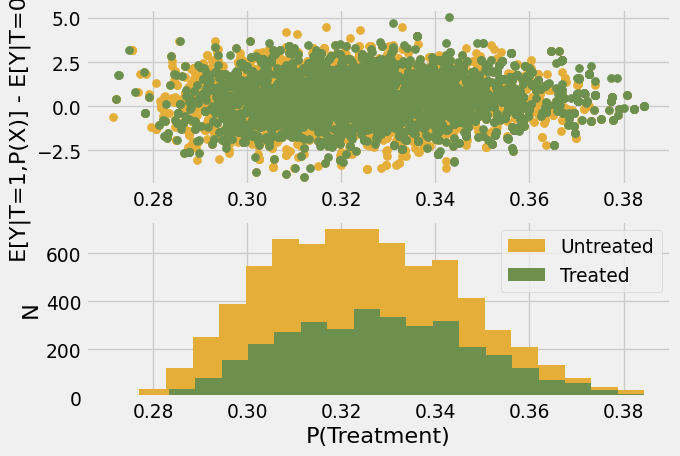

In [26]:
fig, ax = plt.subplots(2,1)
treat = data.intervention
ax[0].scatter(ps[treat==0],tex[treat==0],color="C2")
ax[0].scatter(ps[treat==1],tex[treat==1],color="C3")
ax[1].hist(ps[treat==0],bins=20,color="C2",label="Untreated")
ax[1].hist(ps[treat==1],bins=20,color="C3",label="Treated")
ax[1].set_xlabel("P(Treatment)")
ax[1].set_ylabel("N")
ax[0].set_ylabel("E[Y|T=1,P(X)] - E[Y|T=0,P(X)]")
plt.legend()
plt.show()

## Inverse Propensity Weighting

In [27]:
def ipw(T,Y,X,psmodel=LogisticRegressionCV(scoring='neg_log_loss')):
    pfit = psmodel.fit(X,T)
    ps = pfit.predict_proba(X)[:,1]
    ate=np.mean(Y*(T - ps)/(ps*(1-ps)))
    return(ate,ps)

ate,ps = ipw(data_with_categ[T],data_with_categ[Y],data_with_categ[X])
print(ate)

0.44256557543538383

## Doubly Robust

In [28]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, LogisticRegressionCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures

def robustate(T,Y,X,psmodel=LogisticRegressionCV(scoring='neg_log_loss'),ymodel=LassoCV(), cluster=None):
    pfit = psmodel.fit(X,T)
    ps = pfit.predict_proba(X)[:,1]
    ey1fit = ymodel.fit(X[T==1],Y[T==1])
    ey0fit = sklearn.base.clone(ymodel).fit(X[T==0],Y[T==0])
    ey1 = ey1fit.predict(X)
    ey0 = ey0fit.predict(X)
    ate_terms = ey1 - ey0 + T*(Y- ey1)/ps - (1-T)*(Y-ey0)/(1-ps)
    ate = np.mean(ate_terms)
    # check if cluster is None
    if cluster is None :
        ate_se = np.sqrt(np.var(ate_terms)/len(ate_terms))
    else :
        creg=smf.ols("y ~ 1", pd.DataFrame({"y" : ate_terms})).fit(cov_type="cluster", cov_kwds={'groups': cluster})
        ate_se = np.sqrt(creg.cov_params().iloc[0,0])

    return(ate, ate_se, ps, ey1,ey0)

ate,se,ps,ey1,ey0 = robustate(data_with_categ[T],data_with_categ[Y],data_with_categ[X],cluster=data_with_categ['schoolid'])
print(ate-1.96*se, ate, ate+1.96*se)

0.3317146398974234 0.3832790165781086 0.4348433932587938

[1]

## Doubly Robust

-   better to use the `doubleml` package

[1] We have glossed over some details needed for doubly robust
estimation to have nice statistical properties. Those details matter and
are not implemented correctly above. It is better to use doubleml
instead.

In [29]:
import doubleml as dml

m = LassoCV()
g = LogisticRegressionCV(scoring='neg_log_loss')
dmldata = dml.DoubleMLData(data_with_categ, Y,T,X.to_list())
dmlATE = dml.DoubleMLAPOS(dmldata, m, g, treatment_levels=[0, 1])
dmlATE.fit()
dmlATE.summary
dmlATE.causal_contrast(0).summary

## Sources and Further Reading

-   Useful additional reading is [chapters
    10-12](https://matheusfacure.github.io/python-causality-handbook/10-Matching.html)
    of Facure (2022) and [chapter
    14](https://theeffectbook.net/ch-Matching.html) of Huntington-Klein
    (2021).[1]

-   Chapters 5 and 10 of Chernozhukov et al. (2024)

-   The representation of the estimate from a linear model as a weighted
    average is based on Borusyak and Jaravel (2018)

-   The growth mindset example is take from Facure (2022)

## References

Abadie, Alberto, and Guido W. Imbens. 2008. “On the Failure of the
Bootstrap for Matching Estimators.” *Econometrica* 76 (6): 1537–57.
https://doi.org/<https://doi.org/10.3982/ECTA6474>.

Athey, Susan, and Stefan Wager. 2019. “Estimating Treatment Effects with
Causal Forests: An Application.”

Borusyak, Kirill, and Xavier Jaravel. 2018. “Revisiting Event Study
Designs.”
<https://scholar.harvard.edu/files/borusyak/files/borusyak_jaravel_event_studies.pdf>.

Chernozhukov, V., C. Hansen, N. Kallus, M. Spindler, and V. Syrgkanis.
2024. *Applied Causal Inference Powered by ML and AI*.
<https://causalml-book.org/>.

Facure, Matheus. 2022. *Causal Inference for the Brave and True*.
<https://matheusfacure.github.io/python-causality-handbook/landing-page.html>.

Huntington-Klein, Nick. 2021. *The Effect: An Introduction to Research
Design and Causality*. CRC Press. <https://theeffectbook.net/>.

Yeager, David S., Paul Hanselman, Gregory M. Walton, Jared S. Murray,
Robert Crosnoe, Chandra Muller, Elizabeth Tipton, et al. 2019. “A
National Experiment Reveals Where a Growth Mindset Improves
Achievement.” *Nature* 573 (7774): 364–69.
<https://doi.org/10.1038/s41586-019-1466-y>.

[1] These slides do not mention the importance of overlap/balance, but
hopefully I emphasized it during lecture. Overlap is very important in
practice. The reading, especially Huntington-Klein (2021), cover it
pretty well.